# Importing Libraries


In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.optim as optim
from torchvision import models

# Classification

create dataloaders

In [2]:
#define a transformation function for training and test
train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#create training and test dataset
training = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformation)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformation)

size_batch =32
#create training and test loaders
train_loader = torch.utils.data.DataLoader(training, batch_size=size_batch,shuffle=True, num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=size_batch,shuffle=False, num_workers=2,drop_last=True)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 40816559.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


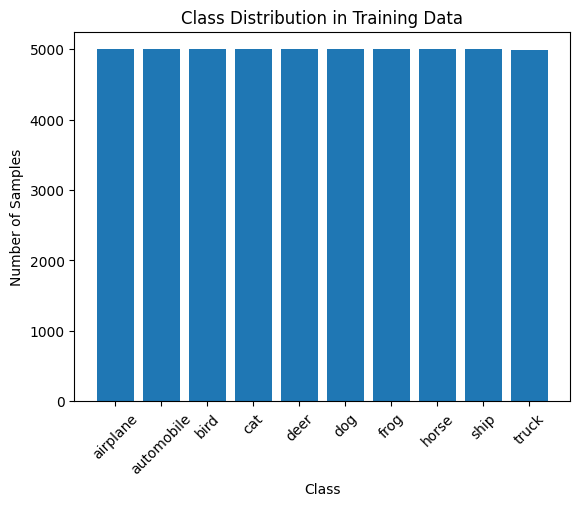

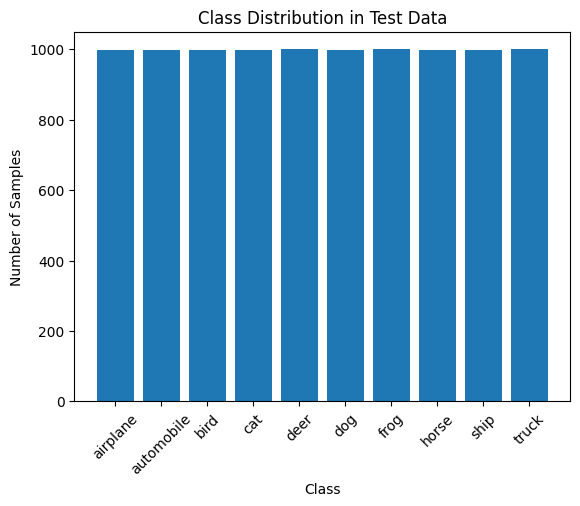

In [3]:
def check_class_distribution(dataset, loader, name):
    classes = dataset.classes
    num_classes = len(classes)
    class_count = np.zeros(10)  #count occurrences of each class
    shape_image = None
    for images, labels in loader:
        if shape_image is None:
            shape_image = images[0].shape
        for label in labels:
            class_count[label] += 1
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()
    return shape_image, num_classes


#distribution for training data
shape_image_train, num_classes_train = check_class_distribution(training,train_loader, "Training Data")
#distribution for test data
shape_image_test, num_classes_test = check_class_distribution(test, test_loader, "Test Data")

In [4]:
#sanity check
if shape_image_train == shape_image_test:
  #input_size = torch.prod(torch.tensor(shape_image_train)).item()
  input_size = torch.tensor(shape_image_train)
if num_classes_train == num_classes_test:
  output_size = num_classes_train
print(input_size, output_size)
'''
print(int(input_size[0]))
print(int(input_size[1]))
print(int(input_size[2]))
'''

tensor([ 3, 32, 32]) 10


'\nprint(int(input_size[0]))\nprint(int(input_size[1]))\nprint(int(input_size[2]))\n'

In [5]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
print(device)

cuda


In [6]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # Freeze convolutional layers
num_ftrs = model.fc.in_features

# Add new final layers (replace with your architecture)

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, output_size)
)

model.to(device)

if next(model.parameters()).is_cuda:
    print("model moved to cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


model moved to cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10) #number of epochs

In [ ]:
import sys
epochs = 15
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        #print(labels.shape)
        #sys.exit()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #normalized_loss = loss.mean() / len(inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        # Print statistics
        running_loss += loss.item()
        #print(f'Epoch [{epoch + 1}/{5}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.3f}')

        if i == len(train_loader) - 1:  # If it's the last mini-batch
            # Print the average loss over the epoch
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / (i + 1):.3f}')
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

Epoch [1/15], Average Loss: 1.785
Epoch [2/15], Average Loss: 1.699
Epoch [3/15], Average Loss: 1.679
Epoch [4/15], Average Loss: 1.659
Epoch [5/15], Average Loss: 1.648
Epoch [6/15], Average Loss: 1.624
Epoch [7/15], Average Loss: 1.611
Epoch [8/15], Average Loss: 1.593
Epoch [9/15], Average Loss: 1.590
Epoch [10/15], Average Loss: 1.585
Epoch [11/15], Average Loss: 1.583
Epoch [12/15], Average Loss: 1.586
Epoch [13/15], Average Loss: 1.591
Epoch [14/15], Average Loss: 1.585
Epoch [15/15], Average Loss: 1.586
Finished Training


In [ ]:
torch.save(model.state_dict(), 'Resnet_model.pth')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Adversarial Training


In [7]:
# Noise
def adversarial_noise(images, epsilon=1):
    """Add random adversarial noise to the images."""
    noise = epsilon * torch.randn_like(images) #random noise
    noised_images = images + noise # adding noise
    return torch.clamp(noised_images, 0, 255) # making sure pixel values are valid

In [ ]:
#Adversarial Training
import sys
epochs = 10 #change it to whatever number you want
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        #print(labels.shape)
        #sys.exit()
        # zero the parameter gradients
        optimizer.zero_grad()
        if i%2 == 0:
          adv_images = adversarial_noise(inputs)
          # forward + backward + optimize
          outputs = model(0.2 * adv_images)
        else:
          outputs = model(inputs)
        loss = criterion(outputs, labels)
        #normalized_loss = loss.mean() / len(inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        #print(f'Epoch [{epoch + 1}/{5}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.3f}')
        if i == len(train_loader) - 1:  # If it's the last mini-batch
            # Print the average loss over the epoch
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / (i + 1):.3f}')
            running_loss = 0.0
    scheduler.step(epoch-1)
print('Finished Training')


Epoch [1/10], Average Loss: 2.338


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/10], Average Loss: 2.280
Epoch [3/10], Average Loss: 2.252
Epoch [4/10], Average Loss: 2.234
Epoch [5/10], Average Loss: 2.224
Epoch [6/10], Average Loss: 2.212
Epoch [7/10], Average Loss: 2.208
Epoch [8/10], Average Loss: 2.203
Epoch [9/10], Average Loss: 2.198
Epoch [10/10], Average Loss: 2.198
Finished Training


In [ ]:
"""Testing the model and print values."""
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    # original and attacked output label
    outputs_orig = model(images)
    _, predicted_orig = torch.max(outputs_orig.data, 1)
    correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()
    # loss
    loss_orig = F.cross_entropy(outputs_orig, labels)

    # labels and loss values
    print("Original labels: ", labels.cpu().numpy())
    print("Loss on original images: ", loss_orig.item())

accuracy_orig = correct_predictions_orig / len(labels)
print(f"Accuracy: {accuracy_orig}")


In [8]:
# FGSM
def FGSM(model, image, epsilon=1):
    """
      The FGSM is an attack method designed to fool models by perturbing the input data slightly in a way that maximizes the loss.
      This function implements FGSM by taking a single image and its label, applying a gradient-based perturbation, and returning the modified image.
      The perturbation magnitude is controlled by `epsilon`, which determines how much to move along the gradient's sign direction.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.

    Output:
    - perturbed_image : The image tensor after the FGSM attack, perturbed such that it aims to maximize the classification loss.
"""
    image.requires_grad = True
    outputs = model(image)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    image_grad = image.grad.data
    sign_image_grad = image_grad.sign()
    perturbed_image = image + epsilon * sign_image_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)

    return perturbed_image

In [9]:
# PGD
def PGD(model, image, epsilon=50,alpha = 1, num_iter = 10):
    """
    The Projected Gradient Descent is an iterative method used to create adversarial examples by subtly and incrementally changing an image to maximize model error.
    This function handles the attack by taking a single image and its label, applying small, controlled changes, and ensuring these changes stay within a defined limit, epsilon.
    The amount adjusted per step is set by alpha, and the process repeats for a specified number of iterations to refine the adversarial effect.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.
    - alpha : The step size for each iteration determining how much the image is modified at each step.
    - num-iter : The number of iterations to perform.

    Output:
    - perturbed_image : The image tensor after the PGD attack.
"""
    image.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    for i in range(num_iter):
      outputs = model(image)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      image_grad = image.grad.data
      sign_image_grad = image_grad.sign()
      attacked_image = image + alpha * sign_image_grad
      dist = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

In [10]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable


def deepfool(model, images, labels, target_labels, steps=50, epsilon=0.001):
    """
    Generate adversarial examples using the DeepFool algorithm for a batch of images.

    Args:
        model (torch.nn.Module): The PyTorch model to attack.
        images (torch.Tensor): Batch of input image tensors (assumes normalized to [0, 1]).
        labels (torch.Tensor): True labels of the images.
        target_labels (torch.Tensor): Target labels to misclassify to.
        steps (int): Number of iterations to find the minimal perturbation.
        epsilon (float): A small constant to avoid division by zero.

    Returns:
        torch.Tensor: Batch of adversarial image tensors.
    """
    # Move images and labels to device (CPU or GPU)
    device = next(model.parameters()).device
    images, labels, target_labels = images.to(device), labels.to(device), target_labels.to(device)

    # Convert images to require gradient computation
    #images = images.clone().detach().requires_grad_(True)
    #images = images.clone().requires_grad_(True)
    #images.requires_grad = True
    image_var = Variable(images.clone(), requires_grad=True)



    # Define optimizer
    #optimizer = torch.optim.Adam([images], lr=0.001)
    optimizer = torch.optim.Adam([image_var], lr=0.001)

    for just_d in range(steps):
        # Forward pass
        #outputs = model(images)
        outputs = model(image_var)

        # Calculate the loss
        loss = F.cross_entropy(outputs, target_labels)

        # Zero gradients, backward pass, and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Retain gradients for computation
        #images.retain_grad()
        image_var.retain_grad()

        # Check if gradients are available
        #if images.grad is None:
        if image_var.grad is None:
            print("image grad is none", just_d)
            break

        # Compute the gradient of the loss w.r.t. the input images
        #gradients = images.grad
        #print('pases this once',just_d)
        gradients = image_var.grad

        # Compute the perturbation using the gradient sign
        perturbation = torch.sign(gradients)

        # Update the images with the perturbation
        #images = images + epsilon * perturbation
        #image_var = image_var + epsilon * perturbation
        image_var.data.add_(epsilon * perturbation)


        # Clip the perturbed images to the valid range [0, 1]
        #images = torch.clamp(images, 0, 1)
        #image_var = torch.clamp(image_var, 0, 1)
        image_var.data.clamp_(0, 1)


        # Check if target label reached for any image in the batch
        if torch.all(torch.eq(torch.argmax(outputs, dim=1), target_labels)):
            break

    # Return the batch of adversarial image tensors
    #return images
    return image_var


In [11]:
#JSM
def JSM(model, image, labels, max_iters = 100, threshold=0.1):
    """
    Jacobian-based Saliency Maps (JSM) explore the forward derivates to calculate the model gradients, replacing the
    gradient descent approaches, and discover which input regions are likely to yield adversarial examples.
    Then it uses saliency maps to construct the adversarial saliency maps, which display the features the adversary must perturb.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - max_iters (int): Maximum number of iterations for the attack.
    - labels : The true labels associated with the image tensor.
    - threshold (float): Threshold for pixel perturbation.

    Output:
    - perturbed_image : The image tensor after the JSM attack.
    """
    model.eval()
    image.requires_grad = True
    batch_size = image.size(0)

    for _ in range(max_iters):
        output = model(image)
        loss = F.cross_entropy(output,labels)
        model.zero_grad()
        loss.backward()

        saliency_map = image.grad.abs().sum(dim=1)
        perturb_mask = saliency_map > threshold
        perturb_values = torch.sign(image.grad) * perturb_mask.float().unsqueeze(1)
        image.data +=perturb_values
        image.grad.data.zero_()

    image = torch.clamp(image,0,1)
    return image


In [12]:
def FIA(model, image, target, epsilon=0.001, alpha=0.01, num_iter=50, drop_prob=0.3, ensemble_num=5):
    """
    Perform Feature Importance-aware Attack (FIA) considers the object-aware features that dominate the model decisions, using the aggregate
    gradient (gradients average concerning the feature maps). This approach avoids local optimum, represents transferable feature importance,
    and uses the aggregate gradient to assign weights identifying the essential features. Furthermore, FIA generates highly transferable
    adversarial examples when extracting the feature importance from multiple classification models.

    Parameters:
    - model: the neural network model (PyTorch model).
    - image: input image tensor
    - target: true label of the image.
    - epsilon: maximum perturbation.
    - alpha: step size for each iteration.
    - num_iter: number of iterations.
    - drop_prob: probability of dropping a pixel.
    - ensemble_num: number of random masks used to compute aggregate gradient.

    Returns:
    - perturbed_image: adversarially perturbed image.
    """
    # Ensuring computation is in evaluation mode to deactivate dropout layers
    #model.eval()

    # Initializing perturbation to zero
    perturbation = torch.zeros_like(image)

    # Looping over the number of iterations
    for _ in range(num_iter):
        # Initializing aggregate gradients to zero
        aggregate_gradients = torch.zeros_like(image)

        # Generating multiple masked versions of the image
        for _ in range(ensemble_num):
            # Applying random pixel dropping
            mask = (torch.rand_like(image) > drop_prob).float()
            masked_image = image * mask
            masked_image.requires_grad = True

            # Forward pass
            output = model(masked_image)
            loss = nn.CrossEntropyLoss()(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculating gradients of model in backward pass
            loss.backward()

            # Accumulating the gradients
            aggregate_gradients += masked_image.grad.data

        # Averaging the gradients over all masked versions
        aggregate_gradients /= ensemble_num

        # Sign of the aggregated gradients
        grad_sign = aggregate_gradients.sign()

        # Updating the perturbation by a small step in the opposite direction of the gradient
        perturbation += alpha * grad_sign
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

    # Apply the perturbation to the original image and clip to maintain valid pixel range
    perturbed_image = image + perturbation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def cw_attack(model, image, target_label, c=1, kappa=0, steps=1000, lr=0.01):
  """
  CW attack implementation in PyTorch.

  Args:
      model: PyTorch model to attack.
      image: Original image tensor (CHW format).
      target_label: Target label for the adversarial image.
      c: Parameter for the box-constraint (default: 1).
      kappa: Confidence parameter for the loss function (default: 0).
      steps: Number of optimization steps (default: 100).
      lr: Learning rate for the optimizer (default: 0.01).

  Returns:
      Adversarial image tensor.
  """
  # Convert image to PyTorch variable and detach gradients
  image_var = Variable(image.clone(), requires_grad=True)

  # Define optimizer
  optimizer = torch.optim.Adam([image_var], lr=lr)

  for step in range(steps):
    # Forward pass
    logits = model(image_var)
    target_logit = logits[0, target_label]
    other_logits = logits.max(dim=1)[0] - target_logit

    # Loss function
    #loss = torch.nn.functional.relu(other_logits - kappa) + c * torch.nn.functional.mse_loss(torch.tanh(image_var) + 1, image)
    relu_loss = torch.nn.functional.relu(other_logits - kappa).mean()
    mse_loss = c * torch.nn.functional.mse_loss(torch.tanh(image_var) + 1, image).mean()
    loss = relu_loss + mse_loss


    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Clip image to valid range (0, 1)
    image_var.data.clamp_(0, 1)

  return image_var.data



In [ ]:

def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_Fia = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)
        adv_images = adversarial_noise(images)
        adv_images2 = FGSM(model, images)
        adv_images3 = PGD(model, images)
        #adv_images4 = FIA(model, images,labels)
        adv_images5 = cw_attack(model, images,target_label)
        adv_images6 = deepfool(model, images,labels,target_label)
        adv_images7 = JSM(model, images,labels)




        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)
        outputs_adv = model(adv_images)
        outputs_adv2 = model(adv_images2)
        outputs_adv3 = model(adv_images3)
        #outputs_adv4 = model(adv_images4)
        outputs_adv5 = model(adv_images5)
        outputs_adv6 = model(adv_images6)
        outputs_adv7 = model(adv_images7)


        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)
        #_, predicted4 = torch.max(outputs_adv4.data, 1)
        _, predicted5 = torch.max(outputs_adv5.data, 1)
        _, predicted6 = torch.max(outputs_adv6.data, 1)
        _, predicted7 = torch.max(outputs_adv7.data, 1)


        total_correct_orig += torch.eq(predicted_orig, labels).sum().item()
        total_correct_noisy += torch.eq(predicted1, labels).sum().item()
        total_correct_fgsm += torch.eq(predicted2, labels).sum().item()
        total_correct_pgd += torch.eq(predicted3, labels).sum().item()
        #total_correct_FIA += torch.eq(predicted4, labels).sum().item()
        total_correct_cw += torch.eq(predicted5, labels).sum().item()
        total_correct_deepfool += torch.eq(predicted6, labels).sum().item()
        total_correct_JSM += torch.eq(predicted7, labels).sum().item()
        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy
    print("Overall Original Accuracy:", total_correct_orig / total_samples)
    print("Overall Accuracy on Noisy Images:", total_correct_noisy / total_samples)
    print("Overall Accuracy on FGSM Images:", total_correct_fgsm / total_samples)
    print("Overall Accuracy on PGD Images:", total_correct_pgd / total_samples)
   # print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)
    print("Overall Accuracy on CW Images:", total_correct_cw / total_samples)
    print("Overall Accuracy on deepfool Images:", total_correct_deepfool / total_samples)
    print("Overall Accuracy on JSM Images:", total_correct_JSM / total_samples)

adversarial_examples(model, test_loader)

Overall Original Accuracy: 0.15344551282051283
Overall Accuracy on Noisy Images: 0.1116786858974359
Overall Accuracy on FGSM Images: 0.11658653846153846
Overall Accuracy on PGD Images: 0.09705528846153846
Overall Accuracy on CW Images: 0.10586939102564102
Overall Accuracy on deepfool Images: 0.19811698717948717
Overall Accuracy on JSM Images: 0.14342948717948717


In [16]:
model.load_state_dict(torch.load('Resnet_model.pth'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:

def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_FIA = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)

        adv_images4 = FIA(model, images,labels)





        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)

        outputs_adv4 = model(adv_images4)



        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)

        _, predicted4 = torch.max(outputs_adv4.data, 1)



        total_correct_FIA += torch.eq(predicted4, labels).sum().item()

        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy

    print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)


adversarial_examples(model, test_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Overall Accuracy on FIA Images: 0.21624599358974358


In [ ]:
adversarial_examples(model, test_loader)

Original labels:  [3 8 8 ... 5 1 7]
Loss on original images:  1.6899163722991943
Loss on noisy adversarial images:  2.381845474243164
Loss on FGSM images:  2.478715419769287
Loss on FGSM images:  2.9160799980163574
Predicted Label for Adversarial Image: [9 0 3 ... 7 2 5]
Predicted Label for Adversarial Image: [3 9 8 ... 0 1 7]
Predicted Label for Adversarial Image: [3 6 1 ... 7 0 8]
loss on noise tensor(2.3818, device='cuda:0', grad_fn=<NllLossBackward0>)
loss on FGSM tensor(2.4787, device='cuda:0', grad_fn=<NllLossBackward0>)
loss on PGD tensor(2.9161, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy: 0.4146
Accuracy: 0.1861
Accuracy: 0.16
Accuracy: 0.091


# Defense

In [ ]:
!pip install opencv-python


In [ ]:
import cv2
def adversarial_examples(model, dataloader):
    """Testing the model with adversarial examples and print loss values."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples (implement these functions or import them)
        adv_images = adversarial_noise(images)  # Placeholder function
        adv_images2 = FGSM(model, images)       # Placeholder function
        adv_images3 = PGD(model, images)        # Placeholder function
        outputs_orig = model(images)
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()


        # Process each adversarial image in the batch
        denoised_images = []
        denoised_images2 = []
        denoised_images3 = []
        for i in range(images.size(0)):
            img = adv_images[i].detach().cpu().numpy().transpose(1, 2, 0)
            img2 = adv_images2[i].detach().cpu().numpy().transpose(1, 2, 0)
            img3 = adv_images3[i].detach().cpu().numpy().transpose(1, 2, 0)

            # Convert images to 8-bit format as expected by OpenCV
            img = (img * 255).astype(np.uint8)
            img2 = (img2 * 255).astype(np.uint8)
            img3 = (img3 * 255).astype(np.uint8)

            # Denoising using OpenCV's function
            denoised_image = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
            denoised_image2 = cv2.fastNlMeansDenoisingColored(img2, None, 10, 10, 7, 21)
            denoised_image3 = cv2.fastNlMeansDenoisingColored(img3, None, 10, 10, 7, 21)

            # Convert back to tensor format
            denoised_image = torch.from_numpy(denoised_image.transpose(2, 0, 1).astype(np.float32) / 255).unsqueeze(0).to(device)
            denoised_image2 = torch.from_numpy(denoised_image2.transpose(2, 0, 1).astype(np.float32) / 255).unsqueeze(0).to(device)
            denoised_image3 = torch.from_numpy(denoised_image3.transpose(2, 0, 1).astype(np.float32) / 255).unsqueeze(0).to(device)

            denoised_images.append(denoised_image)
            denoised_images2.append(denoised_image2)
            denoised_images3.append(denoised_image3)

        denoised_images = torch.cat(denoised_images)
        denoised_images2 = torch.cat(denoised_images2)
        denoised_images3 = torch.cat(denoised_images3)

        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)
        outputs_adv = model(denoised_images)
        outputs_adv2 = model(denoised_images2)
        outputs_adv3 = model(denoised_images3)

        loss_orig = F.cross_entropy(outputs_orig, labels)
        loss_adv = F.cross_entropy(outputs_adv, labels)
        loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        loss_adv3 = F.cross_entropy(outputs_adv3, labels)

        # Print labels and loss values
        print("Original labels: ", labels.cpu().numpy())
        print("Loss on original images: ", loss_orig.item())
        print("Loss on noisy adversarial images: ", loss_adv.item())
        print("Loss on FGSM images: ", loss_adv2.item())
        print("Loss on PGD images: ", loss_adv3.item())

        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)

        correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()
        correct_predictions1 = torch.eq(predicted1, labels).sum().item()
        correct_predictions2 = torch.eq(predicted2, labels).sum().item()
        correct_predictions3 = torch.eq(predicted3, labels).sum().item()

        print("Original Accuracy:", correct_predictions_orig / len(labels))
        print("Accuracy on Noisy Images:", correct_predictions1 / len(labels))
        print("Accuracy on FGSM Images:", correct_predictions2 / len(labels))
        print("Accuracy on PGD Images:", correct_predictions3 / len(labels))

adversarial_examples(model, test_loader)

Original labels:  [3 8 8 ... 5 1 7]
Loss on original images:  1.6899163722991943
Loss on noisy adversarial images:  2.4613592624664307
Loss on FGSM images:  2.616833209991455
Loss on PGD images:  2.91593599319458
Original Accuracy: 0.4146
Accuracy on Noisy Images: 0.1719
Accuracy on FGSM Images: 0.1244
Accuracy on PGD Images: 0.0908


#DnCNN

In [20]:
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = [nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False),
                  nn.ReLU(inplace=True)]
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(features, features, kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(features, channels, kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out


In [ ]:
model = DnCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(10):
    model.train()
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        noisy_images = adversarial_noise(inputs)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            noisy_images = adversarial_noise(inputs)
            outputs = model(noisy_images)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    print(f'Epoch [{epoch+1}/{10}], Loss: {test_loss/len(test_loader):.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 0.1884
Epoch [2/10], Loss: 0.1640
Epoch [3/10], Loss: 0.1656
Epoch [4/10], Loss: 0.1611
Epoch [5/10], Loss: 0.1507
Epoch [6/10], Loss: 0.1435
Epoch [7/10], Loss: 0.1443
Epoch [8/10], Loss: 0.1724
Epoch [9/10], Loss: 0.1376
Epoch [10/10], Loss: 0.1362


In [ ]:
torch.save(model.state_dict(), 'dncnn_model.pth')


In [ ]:
dncnn = DnCNN(channels=3)  # Assuming the model expects 3-channel inputs
dncnn.load_state_dict(torch.load('dncnn_model.pth'))
dncnn.to(device)
dncnn.eval()  # Set the model to evaluation mode

def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_Fia = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)
        adv_images = adversarial_noise(images)
        adv_images2 = FGSM(model, images)
        adv_images3 = PGD(model, images)
        #adv_images4 = FIA(model, images,target_label)
        adv_images5 = cw_attack(model, images,target_label)
        adv_images6 = deepfool(model, images,labels,target_label)
        adv_images7 = JSM(model, images,labels)

        # Denoising using DnCNN (assuming dncnn is defined and loaded)
        denoised_images = dncnn(adv_images)
        denoised_images2 = dncnn(adv_images2)
        denoised_images3 = dncnn(adv_images3)
        #denoised_images4 = dncnn(adv_images4)
        denoised_images5 = dncnn(adv_images5)
        denoised_images6 = dncnn(adv_images6)
        denoised_images7 = dncnn(adv_images7)


        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)
        outputs_adv = model(denoised_images)
        outputs_adv2 = model(denoised_images2)
        outputs_adv3 = model(denoised_images3)
        #outputs_adv4 = model(denoised_images4)
        outputs_adv5 = model(denoised_images5)
        outputs_adv6 = model(denoised_images6)
        outputs_adv7 = model(denoised_images7)


        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)
        #_, predicted4 = torch.max(outputs_adv4.data, 1)
        _, predicted5 = torch.max(outputs_adv5.data, 1)
        _, predicted6 = torch.max(outputs_adv6.data, 1)
        _, predicted7 = torch.max(outputs_adv7.data, 1)


        total_correct_orig += torch.eq(predicted_orig, labels).sum().item()
        total_correct_noisy += torch.eq(predicted1, labels).sum().item()
        total_correct_fgsm += torch.eq(predicted2, labels).sum().item()
        total_correct_pgd += torch.eq(predicted3, labels).sum().item()
        #total_correct_FIA += torch.eq(predicted4, labels).sum().item()
        total_correct_cw += torch.eq(predicted5, labels).sum().item()
        total_correct_deepfool += torch.eq(predicted6, labels).sum().item()
        total_correct_JSM += torch.eq(predicted7, labels).sum().item()
        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy
    print("Overall Original Accuracy:", total_correct_orig / total_samples)
    print("Overall Accuracy on Noisy Images:", total_correct_noisy / total_samples)
    print("Overall Accuracy on FGSM Images:", total_correct_fgsm / total_samples)
    print("Overall Accuracy on PGD Images:", total_correct_pgd / total_samples)
    #print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)
    print("Overall Accuracy on CW Images:", total_correct_cw / total_samples)
    print("Overall Accuracy on deepfool Images:", total_correct_deepfool / total_samples)
    print("Overall Accuracy on JSM Images:", total_correct_JSM / total_samples)

adversarial_examples(model, test_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Overall Original Accuracy: 0.1273036858974359
Overall Accuracy on Noisy Images: 0.26582532051282054
Overall Accuracy on FGSM Images: 0.15584935897435898
Overall Accuracy on PGD Images: 0.09725560897435898
Overall Accuracy on CW Images: 0.2127403846153846
Overall Accuracy on deepfool Images: 0.20963541666666666
Overall Accuracy on JSM Images: 0.18439503205128205


In [21]:
dncnn = DnCNN(channels=3)  # Assuming the model expects 3-channel inputs
dncnn.load_state_dict(torch.load('dncnn_model.pth'))
dncnn.to(device)
dncnn.eval()  # Set the model to evaluation mode
def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_FIA = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)

        adv_images4 = FIA(model, images,labels)

        denoised_images4 = dncnn(adv_images4)





        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)

        outputs_adv4 = model(denoised_images4)



        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)

        _, predicted4 = torch.max(outputs_adv4.data, 1)



        total_correct_FIA += torch.eq(predicted4, labels).sum().item()

        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy

    print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)


adversarial_examples(model, test_loader)

Overall Accuracy on FIA Images: 0.2054286858974359
